In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [17]:
data = pd.read_csv(r'c:\Users\eliza\Downloads\DelayData.csv')

In [18]:
data = data[(data['arrdelay'] >= 0) & (data['depdelay'] >= 0)]

In [19]:
print(data['arrdelay'].describe(), end='\n\n')
print(data['depdelay'].describe())

count    381078.000000
mean         35.708034
std          52.643725
min           0.000000
25%           7.000000
50%          18.000000
75%          43.000000
max        1452.000000
Name: arrdelay, dtype: float64

count    381078.000000
mean         35.397360
std          52.351207
min           0.000000
25%           6.000000
50%          18.000000
75%          43.000000
max        1476.000000
Name: depdelay, dtype: float64


In [20]:
# Nan

for col in data.columns:
    print(col)
    print(data[col].isna().value_counts(), end='\n\n')

depdelay
False    381078
Name: depdelay, dtype: int64

arrdelay
False    381078
Name: arrdelay, dtype: int64

scheduleddepartdatetime
False    381078
Name: scheduleddepartdatetime, dtype: int64

origin
False    381078
Name: origin, dtype: int64

dest
False    381078
Name: dest, dtype: int64

uniquecarrier
False    381078
Name: uniquecarrier, dtype: int64

marketshareorigin
False    381078
Name: marketshareorigin, dtype: int64

marketsharedest
False    381078
Name: marketsharedest, dtype: int64

hhiorigin
False    381078
Name: hhiorigin, dtype: int64

hhidest
False    381078
Name: hhidest, dtype: int64

nonhubairportorigin
False    381078
Name: nonhubairportorigin, dtype: int64

smallhubairportorigin
False    381078
Name: smallhubairportorigin, dtype: int64

mediumhubairportorigin
False    381078
Name: mediumhubairportorigin, dtype: int64

largehubairportorigin
False    381078
Name: largehubairportorigin, dtype: int64

nonhubairportdest
False    381078
Name: nonhubairportdest, dtype: in

There are not many Nans in data so lets just drop these samples.

In [21]:
data.dropna(how='any', inplace=True)

Lets look at the target variable distribution.

<Axes: xlabel='arrdelay', ylabel='Count'>

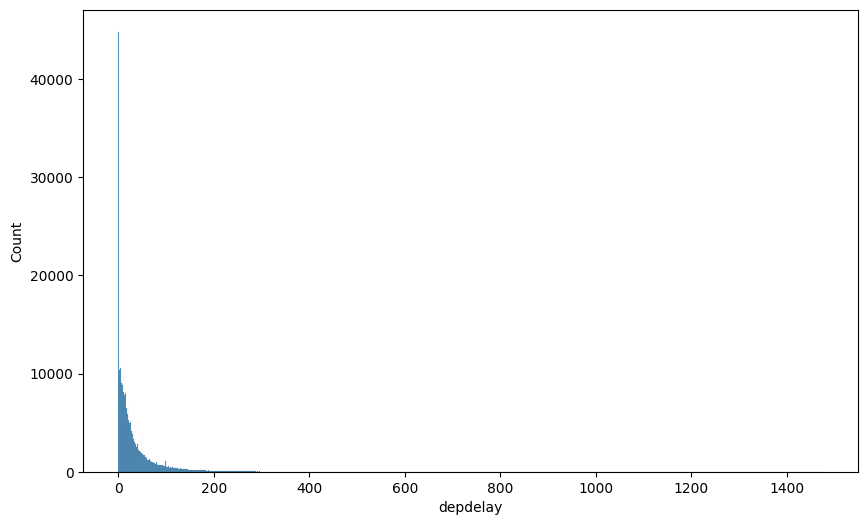

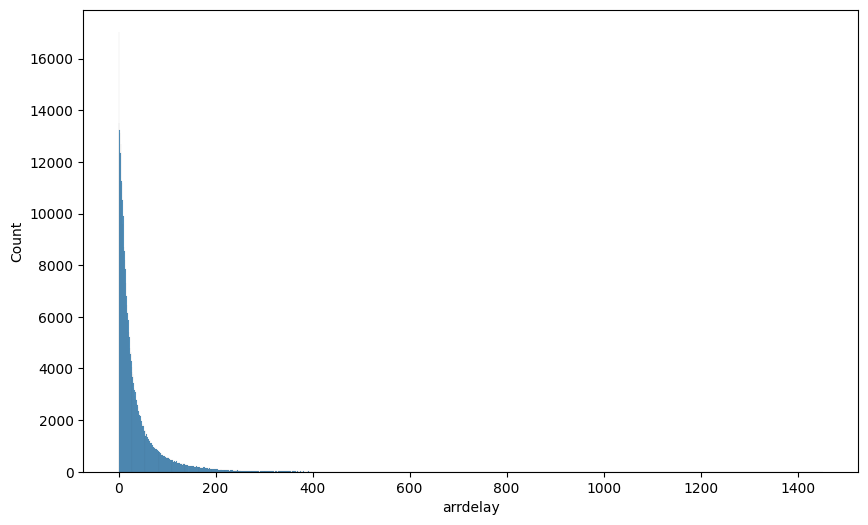

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(data['depdelay'])

plt.figure(figsize=(10, 6))
sns.histplot(data['arrdelay'])

We can see some strong outliers. Lets just delete them.

In [23]:
data = data[(data['depdelay'] < 400)]
data = data[(data['arrdelay'] < 400)]

In [24]:
print('Number of unique destinations:', len(data['dest'].unique()))
print('Number of unique destinations:', len(data['origin'].unique()))

Number of unique destinations: 318
Number of unique destinations: 253


In [25]:
data['route'] = data['origin'] + '-' + data['dest']
data['route'].head()

2     DFW-JFK
8     OAK-LAX
10    ATL-GPT
18    IAH-ORD
21    SMF-SFO
Name: route, dtype: object

In [26]:
print('Number of unique :', len(data['route'].unique()))

Number of unique : 5440


In [27]:
numeric_data = data.select_dtypes(['float64', 'int64'])
bin_features = []

for col in numeric_data.columns:
    if len(numeric_data[col].unique()) == 2:
        numeric_data.drop(col, axis=1, inplace=True)
        bin_features.append(col)

numeric_data.head()

,depdelay,arrdelay,marketshareorigin,marketsharedest,hhiorigin,hhidest,year,month,dayofmonth,dayofweek,...,numflights,distance,temperature,windspeed,windspeedsquare,windgustspeed,originmetropop,originmetrogdppercapita,destmetropop,destmetrogdppercapita
2,3,12.0,0.060898,0.131962,0.296126,0.214357,2004,1,29,4,...,19.545000,1391,12.218868,13.528302,183.014952,0.0,5689982,50588.563,18747431,57295.402
8,0,2.0,0.610661,0.171026,0.396435,0.136749,2004,1,18,7,...,18.440001,337,12.883333,13.233333,175.121111,0.0,4143522,64955.418,12764590,49943.961
10,25,19.0,0.204168,0.504237,0.319589,0.356040,2004,1,3,6,...,17.257999,352,18.813333,6.933333,48.071111,0.0,4802300,49081.773,254385,46664.699
18,23,21.0,0.430083,0.011800,0.332304,0.223560,2004,1,8,4,...,19.579000,925,15.600000,3.000000,9.000000,0.0,5190444,53535.344,9332090,49360.027
21,51,54.0,0.127676,0.265995,0.336400,0.227555,2004,1,16,5,...,19.593000,86,9.000000,2.526316,6.382271,0.0,2004144,44124.023,4143522,64955.418


Lets use isolation forest in order to find the outliers and drop them.

In [28]:
from sklearn.ensemble import IsolationForest

isolation = IsolationForest(contamination=0.02, n_estimators=200, random_state=42)

isolation.fit(numeric_data)

outliers = isolation.predict(numeric_data)

data = data[outliers == 1]

<Axes: xlabel='arrdelay', ylabel='Count'>

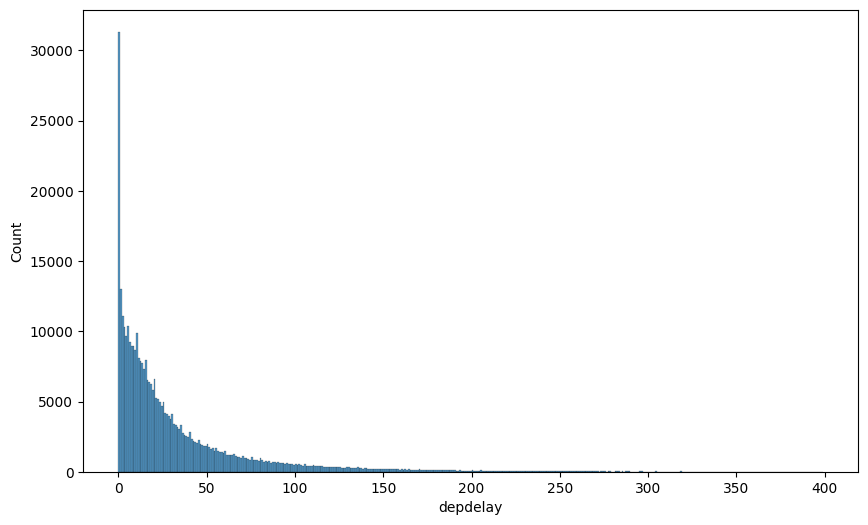

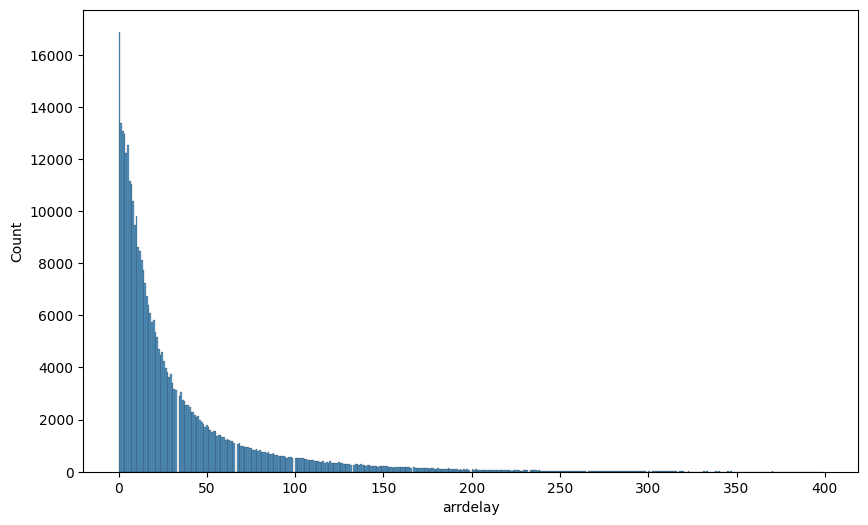

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(data['depdelay'])

plt.figure(figsize=(10, 6))
sns.histplot(data['arrdelay'])

<Axes: >

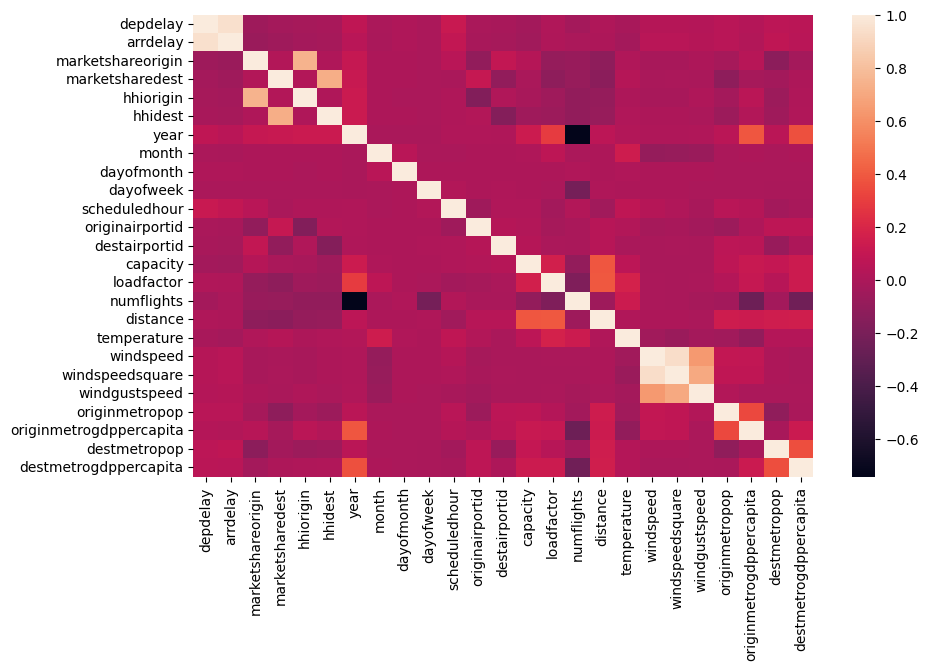

In [30]:
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr())

Windgustspeed and windspeedsquare are highly correlated with windspeed so lets drop it. Year is also useless.

In [31]:
data.drop(['windgustspeed', 'windspeedsquare', 'year'], axis=1, inplace=True)

Lets check the importance of the binary categorical features by using Mann and Whitney test because features dont have normal distribution.

In [32]:
from scipy import stats

useful_cat = []
useless_cat = []

for col in bin_features:
    group1 = data[data[col] == 1]['depdelay']
    group2 = data[data[col] == 0]['depdelay']
    statistic, p_value = stats.mannwhitneyu(group1, group2)
    print(p_value)

    if p_value >= 0.05:
        print(f'{col} dont affect the depdelay')
    else:
        print(f'{col} affects the depdelay')
        useful_cat.append(col)
    
    group1 = data[data[col] == 1]['arrdelay']
    group2 = data[data[col] == 0]['arrdelay']

    if p_value >= 0.05:
        print(f'{col} dont affect the arrdelay')

        if useful_cat[-1] != col:
            useless_cat.append(col)
    else:
        print(f'{col} affects the arrdelay')

        if useful_cat[-1] != col:
            useful_cat.append(col)
    print()

8.223005325115971e-13
nonhubairportorigin affects the depdelay
nonhubairportorigin affects the arrdelay

3.6146215518055405e-51
smallhubairportorigin affects the depdelay
smallhubairportorigin affects the arrdelay

4.3003181738882766e-19
mediumhubairportorigin affects the depdelay
mediumhubairportorigin affects the arrdelay

1.146725491769219e-19
largehubairportorigin affects the depdelay
largehubairportorigin affects the arrdelay

0.02208027068251336
nonhubairportdest affects the depdelay
nonhubairportdest affects the arrdelay

1.310335671433198e-38
smallhubairportdest affects the depdelay
smallhubairportdest affects the arrdelay

5.394092656612756e-07
mediumhubairportdest affects the depdelay
mediumhubairportdest affects the arrdelay

5.52263243445499e-15
largehubairportdest affects the depdelay
largehubairportdest affects the arrdelay

3.9123674565134705e-12
nonhubairlineorigin affects the depdelay
nonhubairlineorigin affects the arrdelay

0.015899947157803594
smallhubairlineorigin 

In [33]:
data.drop(useless_cat, axis=1, inplace=True)
data.drop(['destairportid', 'scheduleddepartdatetime'], axis=1, inplace=True)

Lets do the Kruskal test as we know that we can't apply anova analysis here. Then we will apply Dann test to see what exact feature should be used.

In [34]:
import scikit_posthocs as sp

cats = ['uniquecarrier', 'originstate']

for col in cats:
    unique = data[col].unique()
    groups = [data[data[col] == un]['depdelay'] for un in unique]
    
    statistic, p_value = stats.kruskal(*groups)

    alpha = 0.05
    print(col)
    print(p_value)
    if p_value < alpha:
        print("Reject the null hypothesis.")
        dunn_result = sp.posthoc_dunn(groups, p_adjust='bonferroni')

        print("Dunn test results:")
        print(dunn_result)
    else:
        print("Do not reject the null hypothesis.")
    print()



uniquecarrier
0.0
Reject the null hypothesis.
Dunn test results:
               1              2              3              4              5   \
1    1.000000e+00   2.984385e-11   0.000000e+00   3.921690e-20   1.122193e-11   
2    2.984385e-11   1.000000e+00   0.000000e+00   1.319348e-07   1.062244e-52   
3    0.000000e+00   0.000000e+00   1.000000e+00  5.323216e-301  9.257676e-215   
4    3.921690e-20   1.319348e-07  5.323216e-301   1.000000e+00   9.676201e-46   
5    1.122193e-11   1.062244e-52  9.257676e-215   9.676201e-46   1.000000e+00   
6    1.116174e-36   1.155018e-78   2.141233e-74   2.866970e-72   1.924339e-10   
7   4.223608e-230   0.000000e+00   1.000000e+00  1.355588e-238  3.131215e-145   
8    3.605575e-04   1.000000e+00  6.537265e-175   8.178228e-01   9.601167e-17   
9    1.507036e-03   1.000000e+00   2.183965e-78   1.000000e+00   5.542659e-10   
10   7.382248e-04   3.558901e-17  2.011662e-113   2.918119e-27   1.000000e+00   
11   4.262339e-39   2.976951e-70   1.192250e

In [ ]:
data = pd.get_dummies(data, columns=['originstate', 'uniquecarrier'], drop_first=True)

In [35]:
def target_encode(train_df, test_df, column, target):
    # Вычисляем среднее значение целевой переменной для каждой категории в обучающей выборке
    mean_target = train_df.groupby(column)[target].mean()
    
    # Применяем кодирование к обучающей и тестовой выборкам
    train_df[column + '_encoded'] = train_df[column].map(mean_target)
    test_df[column + '_encoded'] = test_df[column].map(mean_target)
    
    # Заполняем пропуски (если есть категории, которые не встречались в обучающей выборке)
    train_df[column + '_encoded'].fillna(train_df[target].mean(), inplace=True)
    test_df[column + '_encoded'].fillna(train_df[target].mean(), inplace=True)
    
    return train_df, test_df

In [38]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42)

cols = ['origin', 'dest', 'uniquecarrier', 'originairportid', 'tailnum', 'originstate', 'route', 'origincityname']

for col in cols:
    train, test = target_encode(train, test, col, 'arrdelay')
    train, test = target_encode(train, test, col, 'depdelay')


In [39]:
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

<Axes: >

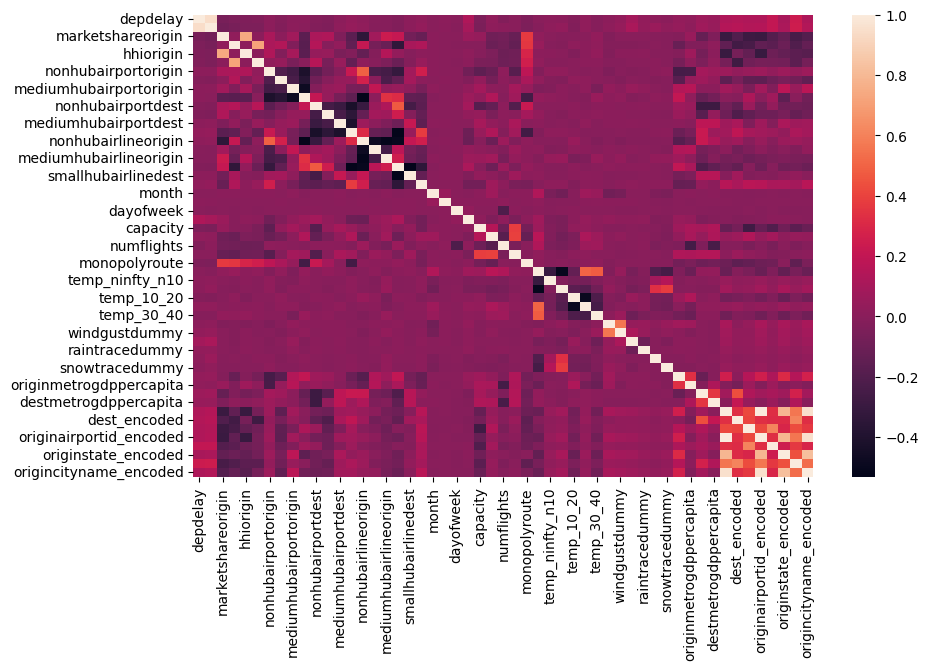

In [41]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr())

In [88]:
y_main = train[['depdelay', 'arrdelay']]
X = train.drop(['depdelay', 'arrdelay'], axis=1)

y_test = test['depdelay']
X_test = test.drop(['depdelay', 'arrdelay'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y_main['depdelay'], random_state=42, test_size=0.25)

In [ ]:
automl = TabularAutoML(task = Task(name = 'reg', metric = 'mse'), reader_params={'rs': 42, 'max_tuning_time': 500})
y_train_pred = automl.fit_predict(train.drop(['arrdelay'], axis=1), roles = {'target': 'depdelay'}, verbose=1)


y_pred = automl.predict(X_valid).data

# Переведем предсказание в формат Series
y_train_pred = pd.Series(y_train_pred.data.flatten())
y_pred = pd.Series(y_pred.flatten())

# Высчитаем метрику roc-auc по валидационным данным
print(f'Метрика MAPE на валидационных данных имеет значение: {mean_absolute_percentage_error(y_valid, y_pred)}')

# Высчитаем метрику roc-auc по тренировочным данным
print(f'Метрика MAPE на тренировочных данных имеет значение: {mean_absolute_percentage_error(y_train, y_train_pred)}')

In [95]:
preds = automl.predict(test.drop(['arrdelay', 'depdelay'], axis=1)).data
y_pred = pd.Series(preds.flatten())

In [103]:
print(f'MAE: {round(mean_absolute_error(test["depdelay"], y_pred), 3)}')

MAE: 27.228


In [104]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)

model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
preds = model.predict(X_valid)

print(f'MAPE: {round(mean_absolute_percentage_error(test["arrdelay"], preds), 3)} %')
print(f'MAE: {round(mean_absolute_error(test["arrdelay"], y_pred), 3)}')